In [1]:
import sys
sys.path.append("../../Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages")

In [2]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
from datasets import load_dataset
import torch
import textwrap
import warnings
warnings.filterwarnings('ignore')
import random

In [3]:
model_to_use = "gpt2-large"
print("Using model: ", model_to_use)
tokenizer = GPT2TokenizerFast.from_pretrained(model_to_use)
model = GPT2LMHeadModel.from_pretrained(model_to_use,output_scores=True,pad_token_id=tokenizer.eos_token_id)

Using model:  gpt2-large


In [4]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from transformers import GPT2Model, GPT2Tokenizer
import matplotlib.pyplot as plt

layers_to_track = ['transformer.h.0.attn.c_attn', 'transformer.h.0.attn.c_proj', 
                   'transformer.h.1.attn.c_attn', 'transformer.h.1.attn.c_proj',
                   'transformer.h.2.attn.c_attn', 'transformer.h.2.attn.c_proj', 
                   'transformer.h.3.attn.c_attn', 'transformer.h.3.attn.c_proj']

class NeuronCoverage:
    def __init__(self, model, tokenizer, top_k=10, activation_threshold=0.1):
        self.model = model
        self.tokenizer = tokenizer
        self.activations = {}
        self.coverage_log = []
        self.handles = []
        self.max_length = 300
        self.top_k = top_k  # For top-K coverage
        self.activation_threshold = activation_threshold  # Dynamic threshold
        self.register_hooks()

    def register_hooks(self):
        for name, module in self.model.named_modules():
            if any(layer_name in name for layer_name in layers_to_track):
                handle = module.register_forward_hook(self.create_hook(name))
                self.handles.append(handle)

    def create_hook(self, layer_name):
        def hook(module, input, output):
            activated_neurons = F.relu(output)
            self.activations[layer_name] = activated_neurons.detach().cpu().numpy()
        return hook

    def compute_coverage(self):
        coverage = {}
        top_k_coverage = {}
        
        for layer_name, activation in self.activations.items():
            # Threshold-based coverage
            above_threshold = activation > self.activation_threshold
            coverage[layer_name] = above_threshold.sum() / above_threshold.size

            # Top-K coverage
            top_k_values = np.partition(activation.flatten(), -self.top_k)[-self.top_k:]
            top_k_above_threshold = top_k_values > self.activation_threshold
            top_k_coverage[layer_name] = np.count_nonzero(top_k_above_threshold) / self.top_k

    # Log results
        self.coverage_log.append((coverage, top_k_coverage))
        return coverage, top_k_coverage

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def process_input(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        return inputs

    def get_model_output(self, inputs, max_length=None):
        max_length = max_length or self.max_length
        input_ids = inputs['input_ids']

        with torch.no_grad():
            output_sequences = self.model.generate(
                input_ids=input_ids,
                max_length=max_length,
                num_return_sequences=1,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.eos_token_id,
                temperature=1.0,
                top_k=50,
                top_p=0.95
            )

        return output_sequences

    def decode_output(self, output_sequences):
        generated_text = self.tokenizer.decode(output_sequences[0], skip_special_tokens=True)
        return generated_text

    def run_coverage_analysis(self, text, apply_mutations=False):
        if apply_mutations:
            text = self.apply_mutations(text) 

        inputs = self.process_input(text)
        output_sequences = self.get_model_output(inputs)
        coverage, top_k_coverage = self.compute_coverage()
        decoded_text = self.decode_output(output_sequences)

        return coverage, top_k_coverage, decoded_text, text

    def apply_mutations(self, text, num_choices=2):
        for _ in range(num_choices):
            mutation_type = random.choice([self.replace_words, self.insert_words, self.reorder_words,
                                           self.swap_characters, self.random_insertion, self.random_deletion])
            text = mutation_type(text)
        return text

    def visualize_coverage(self):
    # Separate the logs for each coverage type
        coverage_values = [cov[0] for cov in self.coverage_log]  # Standard coverage
        top_k_coverage_values = [cov[1] for cov in self.coverage_log]  # Top-K coverage

        # Plotting standard coverage for each layer
        plt.figure(figsize=(12, 6))
        for layer_name in coverage_values[0].keys():
            layer_coverage = [cov[layer_name] for cov in coverage_values]
            plt.plot(layer_coverage, label=f'{layer_name} coverage')

        plt.title("Neuron Coverage Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Coverage")
        plt.legend()
        plt.show()

        # Plotting top-K coverage for each layer
        plt.figure(figsize=(12, 6))
        for layer_name in top_k_coverage_values[0].keys():
            layer_top_k_coverage = [cov[layer_name] for cov in top_k_coverage_values]
            plt.plot(layer_top_k_coverage, label=f'{layer_name} top-K coverage')

        plt.title("Top-K Neuron Coverage Over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Top-K Coverage")
        plt.legend()
        plt.show()

    # Additional Mutation Functions
    def replace_words(self, text):
        words = text.split()
        if len(words) > 0:
            random_idx = random.randint(0, len(words) - 1)
            words[random_idx] = self.generate_random_word()  
        return " ".join(words)

    def insert_words(self, text):
        words = text.split()
        if len(words) > 0:
            random_idx = random.randint(0, len(words) - 1)
            words.insert(random_idx, self.generate_random_word())
        return " ".join(words)

    def reorder_words(self, text):
        words = text.split()
        random.shuffle(words)
        return " ".join(words)
    
    def swap_characters(self, text):
        idx = random.randint(0, len(text) - 2)
        mutated_text = text[:idx] + text[idx+1] + text[idx] + text[idx+2:]
        return mutated_text

    def random_insertion(self, text):
        idx = random.randint(0, len(text) - 1)
        char = random.choice('abcdefghijklmnopqrstuvwxyz')
        mutated_text = text[:idx] + char + text[idx:]
        return mutated_text

    def random_deletion(self, text):
        idx = random.randint(0, len(text) - 1)
        mutated_text = text[:idx] + text[idx+1:]
        return mutated_text

    def generate_random_word(self):
        return ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=5))


In [6]:
coverage_tracker = NeuronCoverage(model,tokenizer)
coverage_tracker.register_hooks()

Neuron Coverage by Layer:
Layer transformer.h.0.attn.c_attn threshold coverage: 42.89%
Layer transformer.h.0.attn.c_proj threshold coverage: 20.55%
Layer transformer.h.1.attn.c_attn threshold coverage: 40.29%
Layer transformer.h.1.attn.c_proj threshold coverage: 30.47%
Layer transformer.h.2.attn.c_attn threshold coverage: 41.22%
Layer transformer.h.2.attn.c_proj threshold coverage: 22.11%
Layer transformer.h.3.attn.c_attn threshold coverage: 42.14%
Layer transformer.h.3.attn.c_proj threshold coverage: 20.94%

Top-K Neuron Coverage by Layer:
Layer transformer.h.0.attn.c_attn top-10 coverage: 100.00%
Layer transformer.h.0.attn.c_proj top-10 coverage: 100.00%
Layer transformer.h.1.attn.c_attn top-10 coverage: 100.00%
Layer transformer.h.1.attn.c_proj top-10 coverage: 100.00%
Layer transformer.h.2.attn.c_attn top-10 coverage: 100.00%
Layer transformer.h.2.attn.c_proj top-10 coverage: 100.00%
Layer transformer.h.3.attn.c_attn top-10 coverage: 100.00%
Layer transformer.h.3.attn.c_proj top-10

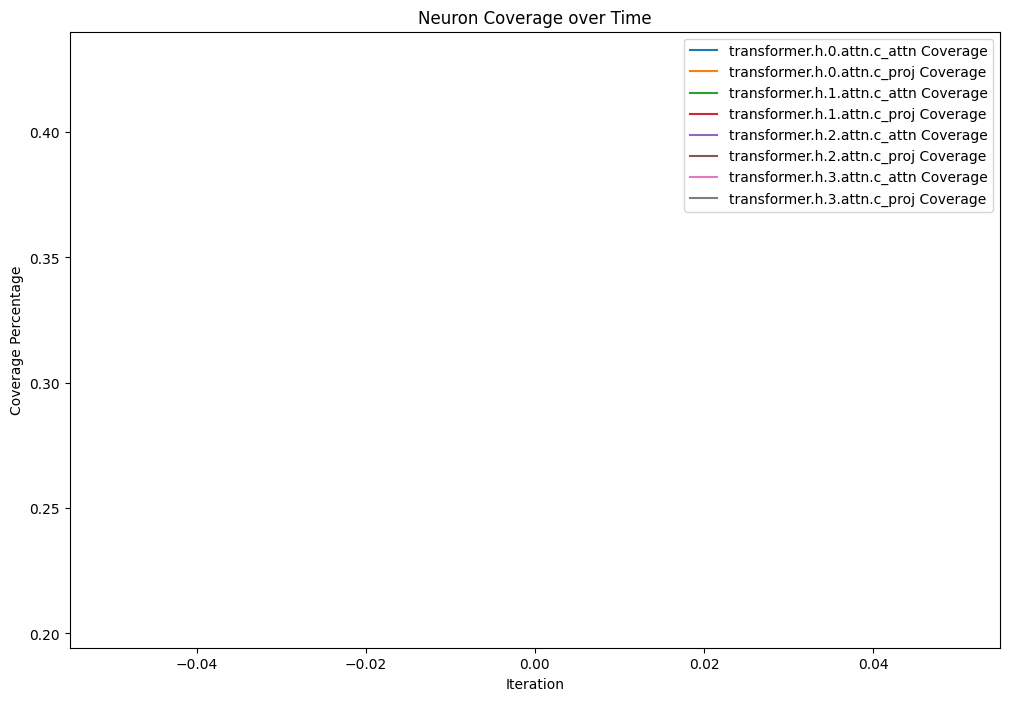

In [7]:
# Define the input text
input_text = "When in the Course of human events, it becomes necessary for one people "

# Run coverage analysis with mutations applied
coverage, top_k_coverage, output_text, mutated_text = coverage_tracker.run_coverage_analysis(input_text, apply_mutations=True)

# Print neuron coverage for each layer
print("Neuron Coverage by Layer:")
for layer, cov in coverage.items():
    print(f"Layer {layer} threshold coverage: {cov:.2%}")

# Print top-K neuron coverage for each layer
print("\nTop-K Neuron Coverage by Layer:")
for layer, top_k_cov in top_k_coverage.items():
    print(f"Layer {layer} top-{coverage_tracker.top_k} coverage: {top_k_cov:.2%}")

# Display mutated input and generated text output
print(f"\nMutated Input: {mutated_text}")
print("\nGenerated Text Output:")
print(output_text)

# Visualize neuron coverage history over multiple iterations
coverage_tracker.visualize_coverage()

# Remove hooks to clean up
coverage_tracker.remove_hooks()


In [9]:
coverage_tracker.remove_hooks()

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Model, GPT2Tokenizer

layers_to_track=['transformer.h.0.attn.c_attn','transformer.h.0.attn.c_proj','transformer.h.1.attn.c_attn','transformer.h.1.attn.c_proj','transformer.h.2.attn.c_attn','transformer.h.2.attn.c_proj','transformer.h.3.attn.c_attn','transformer.h.3.attn.c_proj']

class NeuronCoverage:
    def __init__(self, model, tokenizer):
        self.model = model
        self.activations = {}
        self.tokenizer = tokenizer
        self.handles = []
        self.max_length=300

    def register_hooks(self):
        for name, module in self.model.named_modules():
            if any(layer_name in name for layer_name in layers_to_track):
                handle = module.register_forward_hook(self.create_hook(name))
                self.handles.append(handle)

    def create_hook(self, layer_name):
        def hook(module, input, output):
            # Apply ReLU activation
            activated_neurons = F.relu(output)
            # Count non-zero activations
            activated_neurons = activated_neurons > 0
            # Record activations per neuron
            self.activations[layer_name] = activated_neurons.detach().cpu().numpy()
        return hook

    def compute_coverage(self):
        coverage = {}
        for layer_name, activation in self.activations.items():
            covered_neurons = activation.sum()
            total_neurons = activation.size
            coverage[layer_name] = covered_neurons / total_neurons
        return coverage

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def process_input(self, text):
        """Tokenizes input text and passes it through the model."""
        inputs = self.tokenizer(text, return_tensors="pt")
        return inputs

    def get_model_output(self, inputs, max_length=None):
        max_length = max_length or self.max_length
        input_ids = inputs['input_ids']

        with torch.no_grad():
            output_sequences = self.model.generate(
                input_ids=input_ids,
                max_length=max_length,
                num_return_sequences=1,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.eos_token_id,
                temperature=1.0,
                top_k=50,
                top_p=0.95
            )

        return output_sequences



    def decode_output(self, output_sequences):
        generated_text = self.tokenizer.decode(output_sequences[0], skip_special_tokens=True)
        return generated_text

    
    def run_coverage_analysis(self, text, apply_mutations=False):
        if apply_mutations:
            text = self.apply_mutations(text)  # Apply mutations before processing

        inputs = self.process_input(text)
        output_sequences = self.get_model_output(inputs)
        coverage = self.compute_coverage()
        decoded_text = self.decode_output(output_sequences)

        return coverage, decoded_text, text

    def apply_mutations(self, text, num_choices=2):
        for i in range(0,num_choices):
            mutation_type = random.choice([self.replace_words, self.insert_words, self.reorder_words,self.swap_characters,self.random_insertion,self.random_deletion])
            text = mutation_type(text)
        return text

    def replace_words(self, text):
        words = text.split()
        if len(words) > 0:
            random_idx = random.randint(0, len(words) - 1)
            words[random_idx] = self.generate_random_word()  # Replace random word
        return " ".join(words)

    def insert_words(self, text):
        words = text.split()
        if len(words) > 0:
            random_idx = random.randint(0, len(words) - 1)
            words.insert(random_idx, self.generate_random_word())  # Insert random word
        return " ".join(words)

    def reorder_words(self, text):
        words = text.split()
        random.shuffle(words)  # Shuffle the words randomly
        return " ".join(words)
    
    def swap_characters(self,text):
        idx = random.randint(0, len(text) - 2)
        mutated_text = text[:idx] + text[idx+1] + text[idx] + text[idx+2:]
        return mutated_text

    def random_insertion(self,text):
        idx = random.randint(0, len(text) - 1)
        char = random.choice('abcdefghijklmnopqrstuvwxyz')
        mutated_text = text[:idx] + char + text[idx:]
        return mutated_text

    def random_deletion(self,text):
        idx = random.randint(0, len(text) - 1)
        mutated_text = text[:idx] + text[idx+1:]
        return mutated_text

    def generate_random_word(self):
        # For simplicity, generate a random word of length 5 from the alphabet
        return ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=5))

